# Initial Setup

First we import Pandas and numpy, so that we can access the data. We will also import our raw data values from the dataset.

In [1]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

pd.set_option('display.max_colwidth', 500)

df = pd.read_csv("jeopardy.csv");
display(df)

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,"No. 2: 1912 Olympian; football star at Carlisle Indian School; 6 MLB seasons with the Reds, Giants & Braves",Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,"The city of Yuma in this state has a record average of 4,055 hours of sunshine each year",Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", this company served its billionth burger",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Constitution of Mass., second President of the United States",John Adams
...,...,...,...,...,...,...,...
216925,4999,2006-05-11,Double Jeopardy!,RIDDLE ME THIS,$2000,This Puccini opera turns on the solution to 3 riddles posed by the heroine,Turandot
216926,4999,2006-05-11,Double Jeopardy!,"""T"" BIRDS",$2000,"In North America this term is properly applied to only 4 species that are crested, including the tufted",a titmouse
216927,4999,2006-05-11,Double Jeopardy!,AUTHORS IN THEIR YOUTH,$2000,"In Penny Lane, where this ""Hellraiser"" grew up, the barber shaves another customer--then flays him alive!",Clive Barker
216928,4999,2006-05-11,Double Jeopardy!,QUOTATIONS,$2000,"From Ft. Sill, Okla. he made the plea, Arizona is my land, my home, my father's land, to which I now ask to... return""",Geronimo


# Data Cleaning

So, before we analyze the data, we are going to engage in some data cleaning. Some of the goals are:

- Remove leading spaces in column names
- Reduce column names to one word
- Convert the Points Column to an int64 column
- Divide the Airdate column into datetime column

In [2]:
df.rename(columns = {
    'Show Number': 'shownum',
    ' Air Date' : 'airdate',
    ' Round' : 'round',
    ' Category' : 'category',
    ' Value' : 'points',
    ' Question' : 'question',
    ' Answer' : 'answer'
}, inplace = True);

df.airdate = pd.to_datetime(df.airdate, yearfirst = True)

df.points = df.apply(lambda row : str(row.points).replace(",", "").replace("$", ""), axis = 1)
df.points = df.apply(lambda row : 0 if str(row.points) == "None" else row.points, axis = 1)

df.points = pd.to_numeric(df.points)

## Filter Function

For this project, we will also use this function when we want to filter questions based on the words in those questions. The function can be used in calls such as `getFilteredRows(df, ["King", "House"])`

In [56]:
def getFilteredRows(dataframe, words, operator = "and"):
    data = dataframe.copy()
    
    if operator == "and":
        filterFuntion = lambda row : True if all([word.lower() in row.question.lower().split() for word in words]) else False
    elif operator == "or":
        filterFuntion = lambda row : True if any([word.lower() in row.question.lower().split() for word in words]) else False
    elif operator == "not":
        filterFuntion = lambda row : True if not all([word.lower() in row.question.lower().split() for word in words]) else False
    elif operator == "in_order":
        filterFuntion = lambda row : True if not all([words.lower() in row.question.lower()]) else False

    data["contains"] = data.apply(filterFuntion, axis=1)
    return data[data.contains == True].reset_index()

In [4]:
nonFinalJeopardyQuestions = df[[not val == "Final Jeopardy!" for val in df["round"]]]
display(nonFinalJeopardyQuestions.head())

,shownum,airdate,round,category,points,question,answer
0,4680,2004-12-31,Jeopardy!,HISTORY,200,"For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200,"No. 2: 1912 Olympian; football star at Carlisle Indian School; 6 MLB seasons with the Reds, Giants & Braves",Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200,"The city of Yuma in this state has a record average of 4,055 hours of sunshine each year",Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200,"In 1963, live on ""The Art Linkletter Show"", this company served its billionth burger",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200,"Signer of the Dec. of Indep., framer of the Constitution of Mass., second President of the United States",John Adams


# Average Value of Questions Involving Sports

First, we will use the dataset to find the average value of questions asking about a person's name. We will collect this by using the following keywords:

- Athlete
- Baseball
- Basketball
- Soccer
- Football
- Ball
- Sport

In [75]:
sportQuestions = getFilteredRows(df, 
                                 ["Athlete", "Baseball", "Basketball", "Soccer", "Football", "Ball", "Sport"],
                                operator = "or")

countsOfQuestions = df.groupby(df['round']).count().shownum;
countsOfSportQuestions = sportQuestions.groupby(sportQuestions['round']).count().shownum;
sportPercentageOfQuestions = (countsOfSportQuestions / countsOfQuestions).reset_index();

display(sportPercentageOfQuestions);

,round,shownum
0,Double Jeopardy!,0.008347
1,Final Jeopardy!,0.009915
2,Jeopardy!,0.010225
3,Tiebreaker,NaN


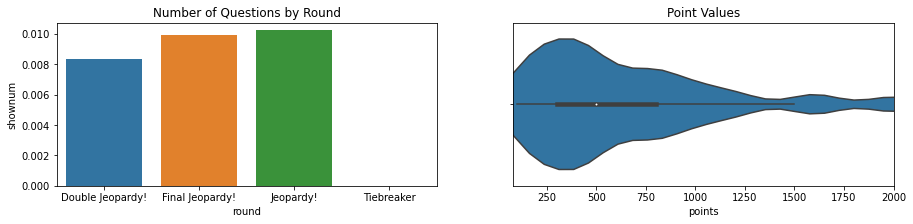

In [78]:
plt.figure(figsize=(15, 3))

plt.subplot(1, 2, 1)
plt.title("Number of Questions by Round")
seaborn.barplot(
    data = sportPercentageOfQuestions,
    x = "round",
    y = "shownum"
)


ax = plt.subplot(1, 2, 2)
plt.title("Point Values")
valuedSportQuestions = sportQuestions[[not val == "Final Jeopardy!" for val in sportQuestions["round"]]]

plt.axis([80, 2000, 0, 1])
seaborn.violinplot(
    data = valuedSportQuestions,
    x = "points"
)

plt.subplots_adjust(hspace=0.5)
plt.show()


Based on these charts, we can see that questions involving sports are most likely to appear as Jeopardy! questions, and least likely to appear as Final Jeopardy! questions. Additionally, we see that they tend to be valued between 250 and 800 points. This suggests that the questions' values are uniformally distributed. 